In [1]:
import os
import re
import numpy as np
import pandas as pd
from collections import Counter
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from bs4 import BeautifulSoup

from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords = nltk.corpus.stopwords.words("english")
warnings.filterwarnings("ignore")

In [2]:
csv_file = "data\IMDB_dataset.csv"
df = pd.read_csv(csv_file)
df = df.iloc[:9999, :]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
### utilities
def remove_special_characters(text):
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('[^a-zA-z0-9\s+\,]','',text)
    text = re.sub('\.{2,}','',text)
    return text

def remove_stopwords(text):
    text = text.lower()
    words = text.split(" ")
    filtered_words = [i for i in words if i not in stopwords]
    filtered_words = ' '.join(filtered_words)
    return filtered_words

class BuildVocab:
    def __init__(self, sentences: pd.Series, vocab_size:int, unk_token=False):
        self.sentences = sentences
        self.vocab_size = vocab_size
        self.oov_token = unk_token
    
    def __process_sentences(self, sentence:str):
        sentence = re.sub(r'[^a-zA-Z\s+]', '', sentence).strip()
        return sentence
    
    def __sentence2words(self, sentence: str):
        word_list = list()
        for word in sentence.split(" "):
            if len(word) >= 1:
                word_list.append(word)
            else:
                pass
        return list(word_list)
    
    def __get_word_dictionary(self, sentences:list):
        words = list()
        for sentence in sentences:
            word_list = self.__sentence2words(sentence=sentence)
            words.extend(word_list)
        return list(words)
    
    def __get_topn_words(self, word_dictionary:dict):
        sorted_items = sorted(word_dictionary.items(), key=lambda item: item[1], reverse=True)
        top_n_words = [word for word, _ in sorted_items[:self.vocab_size]]
        return top_n_words


    def build(self):
        sentences = self.sentences.apply(self.__process_sentences)
        words = self.__get_word_dictionary(sentences=sentences.values)
        word_count_dict = Counter(words)
        vocab = self.__get_topn_words(word_dictionary=word_count_dict)
        
        if self.oov_token:
            vocab.append("UNK")
        else:
            pass

        index_dict = {x: index for x, index in zip(vocab, range(len(vocab)))}

        return vocab, index_dict

In [4]:
print(f"Number of reviews : {len(df['review'].values)}")
print(f"Number of positive and negative reviews : \n**********************\n{pd.DataFrame(df['sentiment'].value_counts())}")

Number of reviews : 9999
Number of positive and negative reviews : 
**********************
           count
sentiment       
positive    5027
negative    4972


In [5]:
## viewing a sample review before applying data transformation
df['review'].values[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [6]:
df['review'] = df['review'].apply(remove_special_characters)
# df['review'] = df['review'].apply(remove_stopwords)

In [7]:
vocab, vocab_dict = BuildVocab(sentences=df['review'], vocab_size=10, unk_token=True).build()

In [8]:
train_x, test_x, train_y, test_y = train_test_split(df['review'].values, df['sentiment'].values, test_size=0.2, random_state=22)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape )

(7999,) (7999,) (2000,) (2000,)


In [9]:
bow = CountVectorizer(max_features=150)
bow = bow.fit(train_x)

bng = CountVectorizer(ngram_range=(3,3))
bng = bng.fit(train_x)

tfidf = TfidfVectorizer(max_features=500)
tfidf = tfidf.fit(train_x)

In [10]:
bow_train_x, bow_test_x = bow.transform(train_x), bow.transform(test_x)
bng_train_x, bng_test_x = bng.transform(train_x), bng.transform(test_x)
tfidf_train_x, tfidf_test_x = tfidf.transform(train_x), tfidf.transform(test_x)

In [11]:
encoder = LabelBinarizer()
encoder = encoder.fit(train_y)


train_y, test_y = encoder.transform(train_y), encoder.transform(test_y)
print(train_y.shape, test_y.shape)

(7999, 1) (2000, 1)


In [12]:
lr_bow = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bow = lr_bow.fit(bow_train_x, train_y)

lr_bng = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_bng = lr_bng.fit(bng_train_x, train_y)

lr_tfidf = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr_tfidf = lr_tfidf.fit(tfidf_train_x, train_y)

In [13]:
bow_train_pred = lr_bow.predict(bow_train_x)
bow_test_pred = lr_bow.predict(bow_test_x)

train_acc_bow = accuracy_score(train_y, bow_train_pred)
train_f1_bow = f1_score(train_y, bow_train_pred)

test_acc_bow = accuracy_score(test_y, bow_test_pred)
test_f1_bow = f1_score(test_y, bow_test_pred)


bng_train_pred = lr_bng.predict(bng_train_x)
bng_test_pred = lr_bng.predict(bng_test_x)

train_acc_bng = accuracy_score(train_y, bng_train_pred)
train_f1_bng = f1_score(train_y, bng_train_pred)

test_acc_bng = accuracy_score(test_y, bng_test_pred)
test_f1_bng = f1_score(test_y, bng_test_pred)

tfidf_train_pred = lr_tfidf.predict(tfidf_train_x)
tfidf_test_pred = lr_tfidf.predict(tfidf_test_x)

train_acc_tfidf = accuracy_score(train_y, tfidf_train_pred)
train_f1_tfidf = f1_score(train_y, tfidf_train_pred)

test_acc_tfidf = accuracy_score(test_y, tfidf_test_pred)
test_f1_tfidf = f1_score(test_y, tfidf_test_pred)



In [14]:
pd.DataFrame({"train_acc" : [train_acc_bow, train_acc_bng, train_acc_tfidf],
              "train_f1" : [train_f1_bow, train_f1_bng, train_f1_tfidf], 
              "test_acc" : [test_acc_bow, test_acc_bng, test_acc_tfidf],
              "test_f1" :  [test_f1_bow, test_f1_bng, test_f1_tfidf]},
              index=['Bag of words', 'Bag of N-grams', 'TFIDF'])


,train_acc,train_f1,test_acc,test_f1
Bag of words,0.759970,0.763430,0.7545,0.759432
Bag of N-grams,1.000000,1.000000,0.8020,0.813559
TFIDF,0.852982,0.854815,0.8265,0.830979


### Explainability

In [64]:
from sklearn.decomposition import PCA

<Axes: xlabel='comp1', ylabel='comp2'>

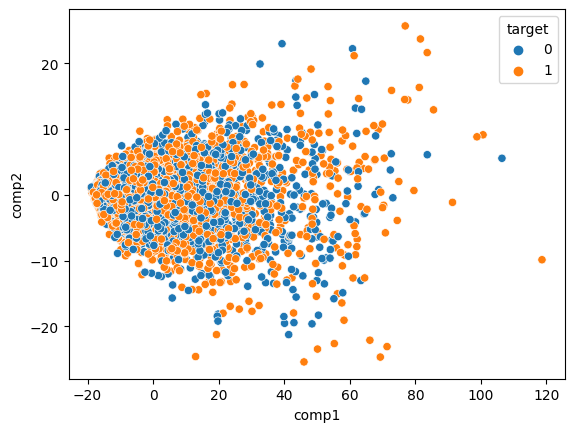

In [79]:
#### decomposed bag of words dataframe
bow_pca = PCA(n_components=2)
bow_pca.fit(bow_train_x.toarray())

pca_bow_train_x = bow_pca.transform(bow_train_x.toarray())
bow_pca_df = pd.DataFrame({"comp1" : pca_bow_train_x[:, 0].tolist(),
                           "comp2" : pca_bow_train_x[:, 1].tolist(),
                           "target" : train_y.flatten().tolist()})

sns.scatterplot(x="comp1", y="comp2", hue="target", data=bow_pca_df)